In [1]:
!pip install chromadb sentence-transformers

In [2]:
# 로컬 파일 저장, 유사도 기반 문장 분류, 문장 클러스터링
# 라이브러리 임포트
import chromadb
from chromadb import PersistentClient   # DB 접속자 역할
from sentence_transformers import SentenceTransformer
import numpy as np # 벡터 연산 및 데이터 처리용

# 1. ChromaDB 설정 및 컬렉션 생성 (RAG의 지식 기반 구축)
client = chromadb.PersistentClient(path='./chroma_db')  # DB 파일 영구 저장

collection = client.get_or_create_collection(name='simple_texts', metadata={'hnsw:space': 'l2'})    # 알고리즘 이름:유클리디안 거리
# get_or_create_collection: 'simple_texts' 컬렉션 생성/가져오기
# metadata={'hnsw:space': 'l2'}: 벡터 간 거리 측정 알고리즘으로 '유클리디안 거리(l2)'를 사용하도록 명시
# hnsw:space: HNSW 알고리즘에서 벡터 간 거리를 계산하는 방법 지정 (l2: 유클리디안, cosine: 코사인 거리 등)


# 2. 벡터화할 텍스트 준비
texts = [
    '사과는 과일이다',
    '파이썬은 프로그래밍 언어다',
    '해는 동쪽에서 뜬다',
    '나는 망고를 좋아해요'
]

ids = [str(i) for i in range(len(texts))]   # 문서 고유 ID 생성
print(ids)


['0', '1', '2', '3']


벡터 거리 측정 방식 (HNSW Space) : RAG 시스템의 검색 성능은 벡터 간의 거리를 어떻게 측정하느냐에 따라 달라짐.

hnsw:space: ChromaDB에서 벡터를 효율적으로 검색하는 HNSW 알고리즘에 사용되는 거리 측정 방식.

* l2 (Euclidean Distance, 유클리디안 거리): 우리가 평소에 생각하는 두 점 사이의 직선 거리. 거리가 짧을수록 유사.
* cosine (Cosine Similarity/Distance): 두 벡터가 가리키는 방향의 유사성을 측정. ChromaDB에서 거리를 반환할 때는 보통 1 - 유사도를 사용하므로, 거리가 짧을수록 유사.


* ChromaDB에서 지원하는 hnsw:space 값
ChromaDB의 HNSW 알고리즘은 주로 다음 세 가지 거리 공간을 지원.

hnsw:space 값	                                  의미      	                                                   특징
l2	                                            유클리디안 거리 (Euclidean Distance)	                            크기와 방향 모두 고려, 거리가 짧을수록 유사
cosine	                                        코사인 거리 (Cosine Distance)                                      방향만 고려, 텍스트 의미 검색에 가장 적합, 거리가 짧을수록 유사
ip	                                            내적 유사도 (Inner Product)                                        크기와 방향 모두 고려, 값이 클수록 유사

In [3]:
# 3. 임베딩 모델 로딩 및 확인
model = SentenceTransformer('all-MiniLM-L6-v2')
print("현재 모델 임베딩 차원 수 : ", model.get_sentence_embedding_dimension())  # 모델의 출력 벡터 차원 수 확인 (384차원)
print(model)

# 4. 텍스트를 벡터로 변환
embeddings = model.encode(texts).tolist()
print(embeddings[:3])   # 변환된 벡터 확인
# model.encode(texts).shape: (문서 수, 차원 수) -> (4, 384)
print(model.encode(texts).shape) 

# 5. 벡터DB에 저장 (RAG 인덱싱)
collection.add(documents=texts, ids=ids, embeddings=embeddings)

현재 모델 임베딩 차원 수 :  384
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
[[-0.036653291434049606, 0.08160002529621124, 0.018218282610177994, -0.009533386677503586, -0.04872555658221245, -0.04989882931113243, 0.12109566479921341, -0.0011590479407459497, -0.007949470542371273, 0.0024379598908126354, 0.1283920854330063, -0.02842545136809349, 0.07470133155584335, -0.05304324999451637, 0.128064826130867, -0.055022839456796646, -0.02528579719364643, -0.012332395650446415, -0.10482940822839737, -0.01936396025121212, 0.018946392461657524, 0.023653093725442886, -0.005153250880539417, 0.04872948303818703, -0.07554057985

In [4]:
# 6. 저장된 벡터 확인
record = collection.get(ids=['0'], include=['embeddings', 'documents'])
print(f"첫번째 문서 : {record['documents'][0]}")
print(f"첫번째 문서의 임베딩 벡터값 : {record['embeddings'][0][:10]}")

# 7. 유사 문장 검색 (RAG Retrieval)
query = '파이썬이 뭐냐' # 질문을 벡터화. SentenceTransformer는 기본적으로 [query] 형태로 입력해야 2차원 배열로 출력됨.
query_vector = model.encode([query]).tolist()
print(model.encode(query).shape, model.encode([query]).shape)    # model.encode(query) -> 1차원 벡터, ([query]) -> 2차원 벡터

# 8. ChromaDB 쿼리 실행
result = collection.query(query_embeddings=query_vector, n_results=2, # 질문 벡터 , 가장 가까운 2개 문서 요청
                          include=["documents","distances"])   # 검색 결과에 포함시킬 항목을 지정
print('검색 결과 :')
for doc, dist in zip(result['documents'][0], result['distances'][0]):
  print(f"문장 : {doc}( 유사도 거리 : {dist:.4f})")
  # -------------------- 유사 문장 검색 끝 --------------------

첫번째 문서 : 사과는 과일이다
첫번째 문서의 임베딩 벡터값 : [-0.03665329  0.08160003  0.01821828 -0.00953339 -0.04872556 -0.04989883
  0.12109566 -0.00115905 -0.00794947  0.00243796]
(384,) (1, 384)
검색 결과 :
문장 : 파이썬은 프로그래밍 언어다( 유사도 거리 : 0.4987)
문장 : 나는 망고를 좋아해요( 유사도 거리 : 0.7733)


In [ ]:
# 9. 유사도 기반 문장 분류기 (클러스터링) 시작
texts2 = [
    "나는 과일을 즐겨 먹는다",
    "바나나는 내가 좋아하는 과일이야",
    "파이썬은 훌륭한 프로그래밍 언어야",
    "나는 가끔 파이썬을 이용해 코딩 하고 있어",
    "사과와 바나나 둘 다 맛이 좋아",
    "파이썬으로 코딩하면 이해가 잘돼",
    "나는 망고 스무디를 즐겨 마셔",
    "과일은 건강한 간식이야",
    "나는 열대 과일을 특히 좋아해"
]

mymodel = SentenceTransformer('all-MiniLM-L6-v2')
myembeddings = model.encode(texts2) # 9개 문장 (9, 384) 벡터 변환
# print(myembeddings[:2])

# 10. K-평균 군집화 (K-Means Clustering) 모델 생성 및 학습
from sklearn.cluster import KMeans

n_clusters = 3    # cluster 개수, k값
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto') # n_init='auto' 추가 (최신 sklearn 권장)
labels = kmeans_model.fit_predict(myembeddings) # fit_predict: 데이터를 모델에 학습시키고(fit), 각 데이터 포인트가 속할 클러스터를 예측(predict)

print(labels)    # 각 문장이 속한 클러스터 번호 (0, 1, 2 중 하나)가 9개 출력

for idx, (text, label) in enumerate(zip(texts2, labels)):
  print(f"[군집 {label}] : {text}")

[1 2 0 0 1 0 1 1 1]
[군집 1] : 나는 과일을 즐겨 먹는다
[군집 2] : 바나나는 내가 좋아하는 과일이야
[군집 0] : 파이썬은 훌륭한 프로그래밍 언어야
[군집 0] : 나는 가끔 파이썬을 이용해 코딩 하고 있어
[군집 1] : 사과와 바나나 둘 다 맛이 좋아
[군집 0] : 파이썬으로 코딩하면 이해가 잘돼
[군집 1] : 나는 망고 스무디를 즐겨 마셔
[군집 1] : 과일은 건강한 간식이야
[군집 1] : 나는 열대 과일을 특히 좋아해


c:\Users\acorn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_init='auto'가 결과에 미치는 영향 분석
1. n_init의 원래 역할: 초기화의 횟수
n_init은 K-Means 알고리즘에서 클러스터 중심(Centroid)을 랜덤하게 몇 번 초기화하여 클러스터링을 실행할지 결정하는 파라미터.

문제점: K-Means는 초기 중심 위치에 따라 최종 결과가 달라지는(지역 최솟값에 빠지는) 경향.
해결책: n_init 값을 크게 설정하면 (예: n_init=10), 알고리즘은 10번 독립적으로 클러스터링을 수행하고, 그중 가장 응집도(inertia)가 좋은 결과를 최종적으로 선택.
기존 기본값: Scikit-learn의 과거 버전에서는 기본값이 10.

2. n_init='auto'와 결과 변화 없음의 이유
Scikit-learn (버전 1.2 이상)에서는 n_init의 기본값이 'auto'로 변경
'auto'의 정의:
n_init이 명시되지 않으면, 'auto'는 효율적인 초기화 방법인 init='kmeans++'를 사용할 때 n_init=1로 설정.
하지만 다른 초기화 방법(예: init='random')을 사용할 때는 과거 기본값인 n_init=10으로 설정.
코드에 적용: 사용자님의 코드에서는 init을 명시하지 않았으므로 기본값인 init='kmeans++'가 사용.
따라서 n_init='auto'는 사실상 n_init=1과 같이 동작.


* 결과가 변하지 않은 이유 (결론)
결과적으로, n_init=10 대신 n_init='auto' (즉, n_init=1)를 사용했음에도 클러스터링 결과(labels)가 눈에 띄게 달라지지 않은 것은 다음과 같은 이유 때문.
데이터의 단순성: 실습에 사용된 9개 문장 데이터는 '과일'과 '파이썬/코딩'이라는 의미적 구분이 매우 명확.
kmeans++의 성능: 사용된 초기화 방법인 kmeans++는 초기 중심을 선택할 때 최대한 멀리 떨어져 있는 지점들을 선택하므로, 단 한 번의 초기화(n_init=1)만으로도 최적 또는 최적에 가까운 결과를 잘 찾음.
요약: 데이터가 명확하게 분리되고 kmeans++를 사용했기 때문에, 초기화 횟수(n_init)를 늘리거나 줄여도 최종 클러스터 결과에는 큰 차이가 없었던 것.

* 실무적 조언
만약 데이터가 매우 복잡하고 클러스터 경계가 모호하다면, 안정적인 결과를 위해 여전히 n_init=10과 같이 큰 값을 명시적으로 설정하여 여러 번 시도하는 것이 좋음.

# 복잡한 데이터라면 안정적인 결과를 위해 n_init을 명시적으로 설정하는 것을 추천
# kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

문장 클러스터링 (K-Means Clustering)
- 비지도 학습(Unsupervised Learning) 방법론인 K-Means 알고리즘을 사용하여 문장의 의미적 그룹을 찾음.

K-Means의 원리:
1. 사용자가 지정한 개수(𝐾=3)만큼 클러스터 중심(Centroid)을 임의로 설정.
2. 모든 문장 벡터를 가장 가까운 중심에 할당.
3. 할당된 데이터 포인트들의 평균 위치로 중심을 갱신.
4. 중심의 위치 변화가 없을 때까지 2\~3단계를 반복.
배운 내용 연결: 벡터 임베딩은 문장의 의미를 담고 있으므로, K-Means는 문장 벡터들을 의미적 유사성이 높은 그룹으로 자동으로 분류.

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


[[ 0.3647493   0.04835347]
 [ 0.51855165 -0.4258749 ]
 [-0.6314922  -0.05766776]
 [-0.4092802  -0.25833538]
 [ 0.48377454  0.03115688]
 [-0.534889   -0.09432949]
 [ 0.13472888  0.15543135]
 [-0.11034489  0.4623075 ]
 [ 0.18420179  0.13895844]]


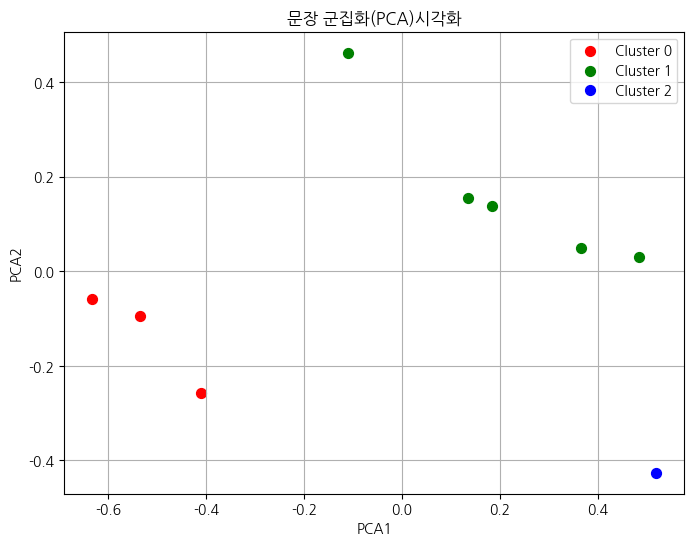

In [6]:
# 군집 결과 시각화
!pip install koreanize-matplotlib   # 한글 폰트 지원 설치

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import koreanize_matplotlib # 한글 깨짐 방지


# PCA: 384차원 벡터를 2차원 평면으로 축소 (시각화를 위해)
pca = PCA(n_components=2)
reduced = pca.fit_transform(myembeddings)
print(reduced)  # (9, 2) 차원 벡터가 됨

plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i in range(n_clusters):
    clusters_points = reduced[labels == i]  # labels == i: i번 클러스터에 속하는 데이터 포인트 인덱싱
    plt.scatter(clusters_points[:,0], clusters_points[:,1], color=colors[i%len(colors)], label=f'Cluster {i}', s=50)
plt.title("문장 군집화(PCA)시각화")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()


* PCA를 활용한 차원 축소 (Visualization)
문제: 문장 벡터는 384차원이기 때문에 시각화할 수 없음.
해결: PCA (Principal Component Analysis, 주성분 분석)를 사용하여 384차원의 복잡한 데이터를 정보 손실을 최소화하면서 2차원(x, y축)으로 축소.
목적: 클러스터링 결과(의미적 그룹핑)가 2차원 평면에서도 시각적으로 명확하게 분리되는지 확인하기 위함.

In [7]:
# 13. 클러스터별 대표 문장 뽑기 (Centroid에 가장 가까운 문장)
from sklearn.metrics import pairwise_distances_argmin_min
# 두 벡터 집합 간의 가장 가까운 쌍(인덱스와의 거리)을 구할때 사용
print('클러스터별 대표 문장 : 중심에 가장 가까움')
for i in range(n_clusters):
    cluster_indices = np.where(labels==i)[0]
    cluster_embeddings = myembeddings[cluster_indices]  # i번 클러스터에 속한 문장들의 벡터 모음
    
    # 중심 벡터(Centroid)
    center = kmeans_model.cluster_centers_[i].reshape(1, -1)

    # 중심 벡터와 클러스터 내의 벡터들 중 가장 가까운 인덱스와 거리 계산
    closets_idx, _ = pairwise_distances_argmin_min(center, cluster_embeddings)
    # 원본 texts2 리스트에서 해당 문장 추출
    closets_text = texts2[cluster_indices[closets_idx[0]]]  # 클러스터 중심에 가장 가까운 문장을 test
    print(f'[Cluster{i}] {closets_text}')

# 14. 클러스터별 전체 문장 출력
print('\n 클러스터별 전체 문장')
for i in range(n_clusters):
    print(f'\n[Cluster{i}]')
    for idx, (text, label) in enumerate(zip(texts2, labels)):
        if label == i:
            print(f' -{text}')
    

클러스터별 대표 문장 : 중심에 가장 가까움
[Cluster0] 파이썬으로 코딩하면 이해가 잘돼
[Cluster1] 나는 열대 과일을 특히 좋아해
[Cluster2] 바나나는 내가 좋아하는 과일이야

 클러스터별 전체 문장

[Cluster0]
 -파이썬은 훌륭한 프로그래밍 언어야
 -나는 가끔 파이썬을 이용해 코딩 하고 있어
 -파이썬으로 코딩하면 이해가 잘돼

[Cluster1]
 -나는 과일을 즐겨 먹는다
 -사과와 바나나 둘 다 맛이 좋아
 -나는 망고 스무디를 즐겨 마셔
 -과일은 건강한 간식이야
 -나는 열대 과일을 특히 좋아해

[Cluster2]
 -바나나는 내가 좋아하는 과일이야


* pairwise_distances_argmin_min (대표 문장 선정)
역할: 클러스터의 중심(Centroid) 벡터와, 그 클러스터에 속한 모든 문장 벡터들 중에서 가장 가까운 거리에 있는 문장(대표 문장)을 찾음.
의미: 클러스터의 중심은 그 그룹이 나타내는 평균적인 의미를 상징. 따라서 중심에 가장 가까운 문장은 해당 클러스터의 가장 대표적인 의미를 가진 문장으로 간주.